# Simple Radio Galaxy Zoo Data Manipulations

In [1]:
import bson
import IPython.core.display
import IPython.display
import matplotlib
import monary
import numpy
import pandas
import pprint
import pymongo
import sklearn.linear_model

# Matplotlib on Mac OS X in a virtualenv doesn't work properly, so we have to force it to use the TkAgg backend.
matplotlib.use('TkAgg')
import matplotlib.pyplot
%matplotlib inline

DB_NAME = 'radio'

In [2]:
# Load up DB.
client = pymongo.MongoClient('localhost', 27017)
db = client[DB_NAME]

In [3]:
# Trying out the subjects DB (following the setup.md example).
subjects = db['radio_subjects']
subject = subjects.find_one()
pprint.pprint(subject)
IPython.display.Image(url=subject['location']['radio'])

{'_id': ObjectId('52af7d53eb9a9b05ef000654'),
 'activated_at': datetime.datetime(2015, 9, 5, 22, 0, 22, 808000),
 'classification_count': 5,
 'coords': [163.13695833333333, 22.891777777777776],
 'created_at': datetime.datetime(2013, 12, 17, 9, 20, 39, 863000),
 'group': {'_id': ObjectId('55f6f8723ae740d851000002'),
           'name': 'first',
           'zooniverse_id': 'GRG0000002'},
 'group_id': ObjectId('55f6f8723ae740d851000002'),
 'location': {'contours': 'http://radio.galaxyzoo.org/subjects/contours/52af7d53eb9a9b05ef000654.json',
              'radio': 'http://radio.galaxyzoo.org/subjects/radio/52af7d53eb9a9b05ef000654.jpg',
              'standard': 'http://radio.galaxyzoo.org/subjects/standard/52af7d53eb9a9b05ef000654.jpg'},
 'metadata': {'contour_count': 1,
              'dec_dms': '22.0 53.0 30.4',
              'ra_hms': '10.0 52.0 32.87',
              'rms': '0.000187',
              'source': 'FIRSTJ105232.8+225330',
              'survey': 'first'},
 'project_id': Objec

In [4]:
IPython.display.Image(url=subject['location']['standard'])

In [5]:
# Trying out the classifications DB.
classifications = db['radio_classifications']
for classification in classifications.find():
    # Get a classification that has annotations.
    annotations = classification['annotations'][0]
    if 'ir' in annotations:
        break

print(classification['annotations'][0]['ir']['0'])
print(classification['annotations'][0]['radio']['0'])
sid = classification['subject_ids'][0]
pprint.pprint(classification)

{'y': '380', 'x': '112'}
{'ymin': '259.9727595144465', 'xmin': '73.02375854060725', 'ymax': '279.7878048157555', 'xmax': '86.77171365343739'}
{'_id': ObjectId('52b0240e2b60f1254400145f'),
 'annotations': [{'ir': {'0': {'x': '112', 'y': '380'}},
                  'radio': {'0': {'xmax': '86.77171365343739',
                                  'xmin': '73.02375854060725',
                                  'ymax': '279.7878048157555',
                                  'ymin': '259.9727595144465'}}},
                 {'ir': {'0': {'x': '214', 'y': '211'}},
                  'radio': {'0': {'xmax': '158.6582798829562',
                                  'xmin': '130.35688465193564',
                                  'ymax': '198.9501488105795',
                                  'ymin': '150.72371665247624'},
                            '1': {'xmax': '176.9758706071857',
                                  'xmin': '148.31174070355846',
                                  'ymax': '131.22621569098413

In [6]:
# Trying out Monary.
with monary.Monary() as mon:
    columns = ['classification_count', 'state']
    subjects_data = mon.query(DB_NAME, 'radio_subjects', {},
                              columns, ['uint8', 'string:20'])
subjects_dataframe = pandas.DataFrame(numpy.ma.filled(subjects_data).T, columns=columns)
subjects_dataframe.head()

# One thing I can't figure out is how to load an entire nested bson doc, e.g. the entire location property.
# I also can't figure out how to query by ID. I know that I can specify properties in find_one and also in the
# monary query, but this doesn't seem to work for ID (possibly due to its type?).

,classification_count,state
0,b'5',b'complete'
1,b'5',b'complete'
2,b'0',b'inactive'
3,b'5',b'complete'
4,b'0',b'inactive'


To demonstrate basic logistic regression, I will map classification count to whether or not subjects are complete.

In [7]:
# Get the data into types we can use.
subjects_dataframe['complete'] = subjects_dataframe['state'] == b'complete'
subjects_dataframe['classification_count'] = subjects_dataframe['classification_count'].astype(int)
subjects_dataframe.head()

,classification_count,state,complete
0,5,b'complete',True
1,5,b'complete',True
2,0,b'inactive',False
3,5,b'complete',True
4,0,b'inactive',False


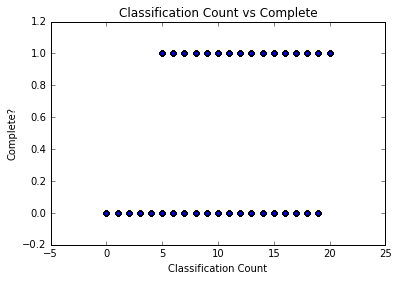

In [8]:
# Let's look at the data to see how separable it is.
subjects_dataframe = subjects_dataframe.sort_values(by='classification_count')

samples = 150000
features = numpy.vstack([subjects_dataframe['classification_count'][:samples],
                         numpy.ones(samples)]).T
targets = subjects_dataframe['complete'][:samples].astype(float)

matplotlib.pyplot.scatter(features[:, 0], targets)
matplotlib.pyplot.title('Classification Count vs Complete')
matplotlib.pyplot.xlabel('Classification Count')
matplotlib.pyplot.ylabel('Complete?')
matplotlib.pyplot.show()

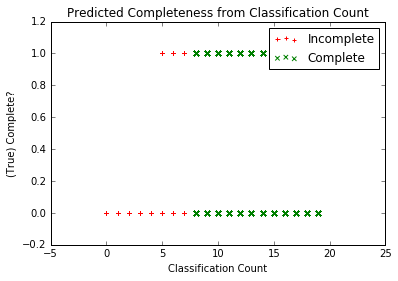

In [9]:
# Not very linearly separable/separable at all. Let's try separating it anyway.
lr = sklearn.linear_model.LogisticRegression()
lr.fit(features, targets)

predictions = lr.predict(features)
incomplete_features = features[predictions < 0.5]
complete_features = features[predictions > 0.5]
incomplete_predictions = targets[predictions < 0.5]
complete_predictions = targets[predictions > 0.5]

matplotlib.pyplot.scatter(incomplete_features[:, 0], incomplete_predictions, c='r', marker='+')
matplotlib.pyplot.scatter(complete_features[:, 0], complete_predictions, c='g', marker='x')
matplotlib.pyplot.title('Predicted Completeness from Classification Count')
matplotlib.pyplot.xlabel('Classification Count')
matplotlib.pyplot.ylabel('(True) Complete?')
matplotlib.pyplot.legend(['Incomplete', 'Complete'])
matplotlib.pyplot.show()

That seems a sensible result.